# UNHCR Population Statistics
Belicia Rodriguez

11/21/2019 (Updated 9/25/20)

In [4]:
# download packages
library(tidyverse)
library(knitr)
library(ggplot2)
library(scales)

oldw <- getOption("warn")
options(warn = -1)

options(scipen=999)

The UNHCR Refugee Agency provides population statistics for different subgroups of refugee populations. The data-set "unhcr_popstats.csv" includes roughly 260 countries and contains data between 1950-2018. The following code downloads the document, cleans the data (i.e changing variable names, defining column types, defining NA values), adds regional groupings to the data-set, view data-set information, and graphs regional groups vs average populations in a time series.

This Jupyter notebook (adapted from RMarkdown file) accompanies section 2 of my project report titled, "Historical Development of Refugee Crises and Aid Response". A writing sample of this report, where I go into a more in-depth analysis of the results found in this RMarkdown, can be found on my website: (TBD)

A note on update: My previous code was a bit too long, so I rewrote the code to be shorter and more efficient. I also cleaned up the ggplot graph code as well.

# Download Data-set & Clean Data

We'll be downloading "unhcr_popstats.csv" into our environment, changing the variable names to be more programming friendly, and looking at the first five rows of the data-frame. Afterwards, we'll replace blank strings ("") with NA values, change the variable data types, and fix the unicode spelling errors that most likely occured when the data was imported.

In [2]:
# download data-set, rename variables, and assign data-types
pop_stat <- read.csv("unhcr_popstats.csv", skip=3) %>% 
  rename(
    "year" = `Year`, 
    "country_territory_of_asylum_residence" = `Country...territory.of.asylum.residence`, 
    "origin" = `Origin`, 
    "refugee_including_refugeelike_situations" = `Refugees..incl..refugee.like.situations.`, 
    "asylum_seekers_pending_cases" = `Asylum.seekers..pending.cases.`, 
    "returned_refugees" = `Returned.refugees`, 
    "internally_displaced_persons" = `Internally.displaced.persons..IDPs.`, 
    "returned_IDPs" = `Returned.IDPs`, 
    "stateless_persons" = `Stateless.persons`, 
    "others_of_concern" = `Others.of.concern`, 
    "total_population" = `Total.Population`
    ) 
# view imported data
head(pop_stat)

,year,country_territory_of_asylum_residence,origin,refugee_including_refugeelike_situations,asylum_seekers_pending_cases,returned_refugees,internally_displaced_persons,returned_IDPs,stateless_persons,others_of_concern,total_population
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
1,1951,Australia,Various/Unknown,180000,,,NA,NA,,,180000
2,1951,Austria,Various/Unknown,282000,,,NA,NA,,,282000
3,1951,Belgium,Various/Unknown,55000,,,NA,NA,,,55000
4,1951,Canada,Various/Unknown,168511,,,NA,NA,,,168511
5,1951,"China, Hong Kong SAR",Various/Unknown,30000,,,NA,NA,,,30000
6,1951,Denmark,Various/Unknown,2000,,,NA,NA,,,2000


In [5]:
# replace empty string with NA
pop_stat$refugee_including_refugeelike_situations[pop_stat$refugee_including_refugeelike_situations==""] <- NA
pop_stat$returned_refugees[pop_stat$returned_refugees==""] <- NA
pop_stat$asylum_seekers_pending_cases[pop_stat$asylum_seekers_pending_cases==""] <- NA
pop_stat$stateless_persons[pop_stat$stateless_persons==""] <- NA
pop_stat$others_of_concern[pop_stat$others_of_concern==""] <- NA

# replace "Various/Unknown" value with NA
pop_stat$country_territory_of_asylum_residence[
  pop_stat$country_territory_of_asylum_residence=="Various/Unknown"] <- NA
pop_stat$origin[pop_stat$origin=="Various/Unknown"] <- NA


# change data types
pop_stat <- pop_stat %>% 
  mutate(
    country_territory_of_asylum_residence = as.factor(country_territory_of_asylum_residence),
    origin = as.factor(origin),
    refugee_including_refugeelike_situations = as.integer(refugee_including_refugeelike_situations),
    asylum_seekers_pending_cases = as.integer(asylum_seekers_pending_cases), 
    returned_refugees = as.integer(returned_refugees), 
    stateless_persons = as.integer(stateless_persons), 
    others_of_concern = as.integer(others_of_concern), 
    total_population = as.integer(total_population)
    )

# fix country names in both asylum_residence and origin
for (var in c(pop_stat$country_territory_of_asylum_residence, pop_stat$origin)) {
  levels(var)[levels(var)=="Serbia and Kosovo (S/RES/1244 (1999))"] <- "Serbia and Kosovo"
  levels(var)[levels(var)=="C\xf4te d'Ivoire"] <- "Côte d'Ivoire"
  levels(var)[levels(var)=="Cura\xe7ao"] <- "Curaçao"
  levels(var)[levels(var)=="Serbia and Kosovo (S/RES/1244 (1999))"] <- "Serbia and Kosovo"
  levels(var)[levels(var)=="C\xf4te d'Ivoire"] <- "Côte d'Ivoire"
  levels(var)[levels(var)=="Cura\xe7ao"] <- "Curaçao"
  levels(var)[levels(var)=="Dem. People's Rep. of Korea"] <- "Rep. of Korea"
  levels(var)[levels(var)=="Palestinian"] <- "State of Palestine"
}

# view cleaned data-set
head(pop_stat)

,year,country_territory_of_asylum_residence,origin,refugee_including_refugeelike_situations,asylum_seekers_pending_cases,returned_refugees,internally_displaced_persons,returned_IDPs,stateless_persons,others_of_concern,total_population
,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1951,Australia,NA,180000,NA,NA,NA,NA,NA,NA,180000
2,1951,Austria,NA,282000,NA,NA,NA,NA,NA,NA,282000
3,1951,Belgium,NA,55000,NA,NA,NA,NA,NA,NA,55000
4,1951,Canada,NA,168511,NA,NA,NA,NA,NA,NA,168511
5,1951,"China, Hong Kong SAR",NA,30000,NA,NA,NA,NA,NA,NA,30000
6,1951,Denmark,NA,2000,NA,NA,NA,NA,NA,NA,2000


# Add Regional Categorizations

The RScript "add_UN_regions.R" contains character vectors of all the countries that belong to a designated region. These regions are defined using the Sustainable Development Goals (SGD) regional groups, which can be found [on this website](https://unstats.un.org/sdgs/indicators/regional-groups). The character vectors are then used in the "add_UN_regions" function, which assigns each row of the data-frame, based on either the country of asylum residence or origin, the region of that location. The following cell runs that function for our data-set.

In [6]:
# import add_UN_regions function (& other vectors in script)
source("add_UN_regions.R")

# add regions to data-set
pop_stat <- add_UN_regions(pop_stat)

# view data-set with added regions
head(pop_stat)

,year,country_territory_of_asylum_residence,origin,refugee_including_refugeelike_situations,asylum_seekers_pending_cases,returned_refugees,internally_displaced_persons,returned_IDPs,stateless_persons,others_of_concern,total_population,region_asylum_residence,region_origin
,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>
1,1951,Australia,NA,180000,NA,NA,NA,NA,NA,NA,180000,oceania,NA
2,1951,Austria,NA,282000,NA,NA,NA,NA,NA,NA,282000,europe_northern_america,NA
3,1951,Belgium,NA,55000,NA,NA,NA,NA,NA,NA,55000,europe_northern_america,NA
4,1951,Canada,NA,168511,NA,NA,NA,NA,NA,NA,168511,europe_northern_america,NA
5,1951,"China, Hong Kong SAR",NA,30000,NA,NA,NA,NA,NA,NA,30000,eastern_southeastern_asia,NA
6,1951,Denmark,NA,2000,NA,NA,NA,NA,NA,NA,2000,europe_northern_america,NA


# Data-set Information

A glimpse into our dataframe "pop_stat" shows that "country_territory_of_asylum_residence", "origin", "region_asylum_residence", and "region_origin" are factor variables containing information about the countries and region for that observation. The variables denoting subgroups (i.e refugee_including_refugeelike_situations) are integer variable types containing the population of the subgroup for that country/region and year. The year variable gives the year for that population information.

In [7]:
glimpse(pop_stat)

Rows: 138,788
Columns: 13
$ year                                     <int> 1951, 1951, 1951, 1951, 1951…
$ country_territory_of_asylum_residence    <fct> "Australia", "Austria", "Bel…
$ origin                                   <fct> NA, NA, NA, NA, NA, NA, NA, …
$ refugee_including_refugeelike_situations <int> 180000, 282000, 55000, 16851…
$ asylum_seekers_pending_cases             <int> NA, NA, NA, NA, NA, NA, NA, …
$ returned_refugees                        <int> NA, NA, NA, NA, NA, NA, NA, …
$ internally_displaced_persons             <int> NA, NA, NA, NA, NA, NA, NA, …
$ returned_IDPs                            <int> NA, NA, NA, NA, NA, NA, NA, …
$ stateless_persons                        <int> NA, NA, NA, NA, NA, NA, NA, …
$ others_of_concern                        <int> NA, NA, NA, NA, NA, NA, NA, …
$ total_population                         <int> 180000, 282000, 55000, 16851…
$ region_asylum_residence                  <fct> oceania, europe_northern_ame…
$ region_origin           

By looking at the proportion of NA's for each variable, we can see that "returned_refugees", "internally_displaced_persons", "returned_IDPs", "stateless_persons", and "others_of_concern" have more than 95% of their values as NA. "asylum_seekers_pending_cases" has a little less than half of their values as NA. "refugee_including_refugeelike_situations" has a quarter of their values as NA, and total population has only 3.44% NA values. "country_territory_of_asylum_residence" and "origin" have less than 2.5% NA values, whereas "region_asylum_residence" has 1.4% and "region_origin" has 7.4%. The differences in the population and region value have to do with some countries not having been categorized in a region in the SDG regional groupings.

In [8]:
data.frame("prop_NA" = round(colMeans(is.na(pop_stat)),4))

,prop_NA
,<dbl>
year,0.0000
country_territory_of_asylum_residence,0.0018
origin,0.0245
refugee_including_refugeelike_situations,0.2479
asylum_seekers_pending_cases,0.4969
returned_refugees,0.9507
internally_displaced_persons,0.9961
returned_IDPs,0.9981
stateless_persons,0.9931


# Graphs

## Asylum Residence Data

The asylum residence data is a subset of the "pop_stat" data-frame with columns "year", "region_asylum_residence", and "total_population". "asylum_df" is created by grouping the data by "year" and "region_asylum_residence", then using summarize to create a new variable "avg_pop", which takes the average of the total population for each year and region combination. The NA values are dropped. We've also included the summary of the data-frame to display the data statistical information.

In [9]:
asylum_df <- pop_stat %>% 
  select(year, region_asylum_residence, total_population) %>%
  group_by(region_asylum_residence, year) %>%
  summarize(avg_pop = mean(total_population)) %>%
  drop_na() %>%
  as.data.frame()

summary(asylum_df)

`summarise()` regrouping output by 'region_asylum_residence' (override with `.groups` argument)



                 region_asylum_residence      year         avg_pop        
 central_southern_asia       :55         Min.   :1951   Min.   :   146.6  
 eastern_southeastern_asia   :54         1st Qu.:1974   1st Qu.:  5111.5  
 europe_northern_america     :66         Median :1988   Median : 17669.5  
 latin_america_caribbean     :48         Mean   :1988   Mean   : 45441.0  
 northern_africa_western_asia:66         3rd Qu.:2002   3rd Qu.: 37789.7  
 oceania                     :46         Max.   :2016   Max.   :742565.0  
 sub_saharan_africa          :57                                          

The "asylum_df" line graph shows the trends in the average "total population" of refugees entering each region for asylum residence.

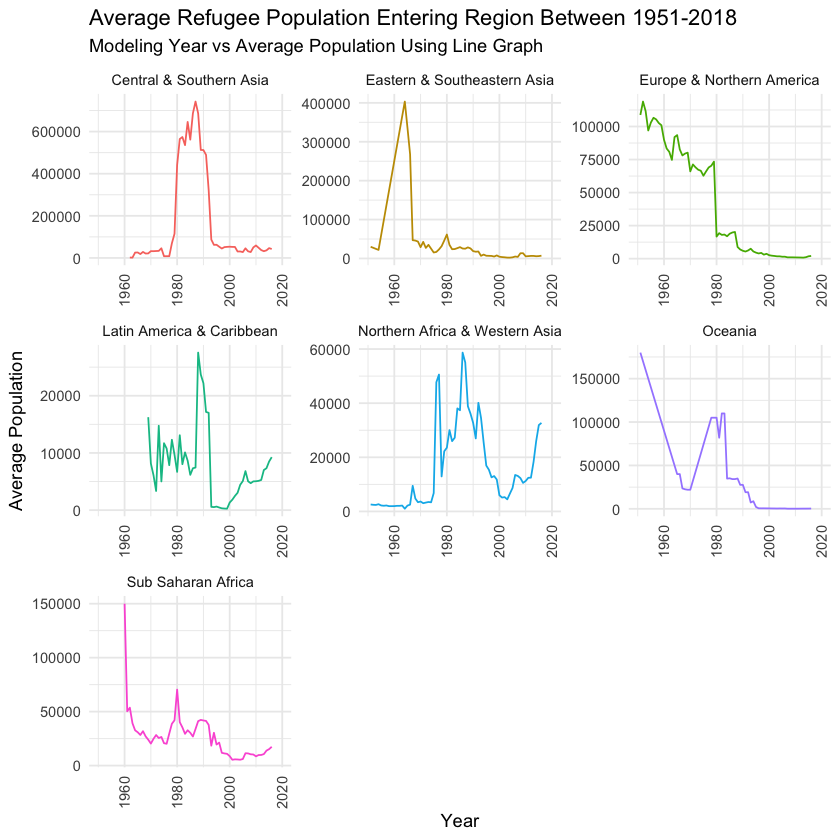

In [10]:
ggplot(asylum_df, aes(x=year, y=avg_pop, color = region_asylum_residence)) +
  geom_line() +
  labs(
    title="Average Refugee Population Entering Region Between 1951-2018", 
    subtitle="Modeling Year vs Average Population Using Line Graph", 
    x="Year", 
    y="Average Population"
    ) +
  scale_x_continuous(limits = c(1950,2020)) + 
  facet_wrap(
    ~region_asylum_residence, 
    scales='free', 
    labeller = labeller(region_asylum_residence = rename_region)
    ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
    legend.position="none"
    )

# ggsave("figures/region_asylum_linegraph.jpeg")

The "asylum_df" boxplot shows average refugee "total population" quartiles for each region.

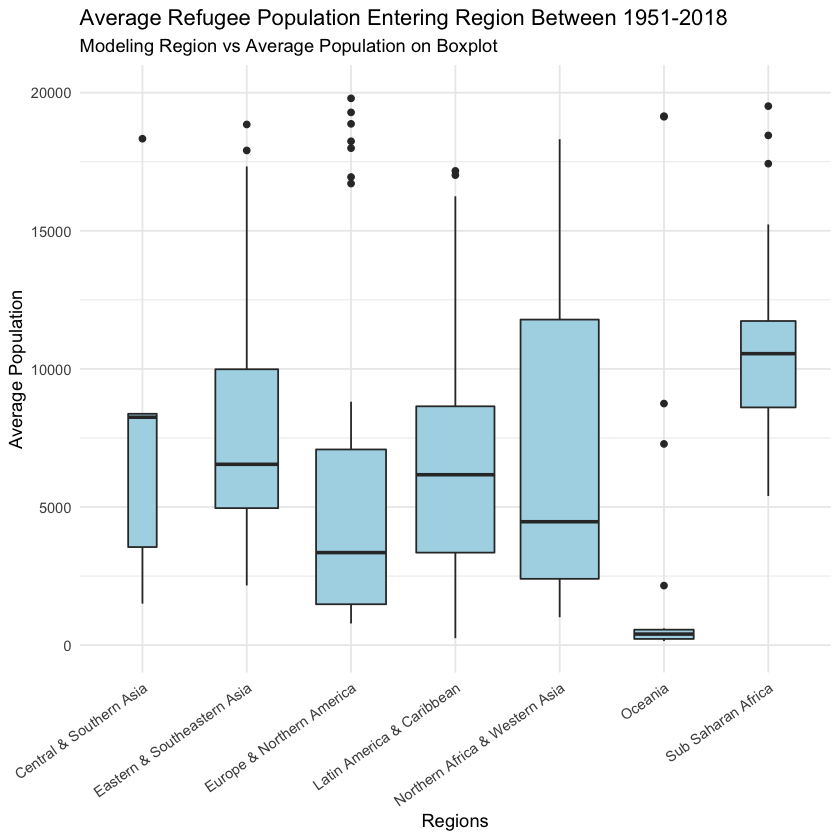

In [11]:
ggplot(asylum_df, aes(x=region_asylum_residence, y=avg_pop)) +
  geom_boxplot(varwidth = T, fill="light blue") +
  labs(
    title = "Average Refugee Population Entering Region Between 1951-2018",
    subtitle = "Modeling Region vs Average Population on Boxplot",
    x = "Regions",
    y = "Average Population"
  ) +
  scale_x_discrete(labels=rename_region) +
  scale_y_continuous(limits = c(0,20000)) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 35, hjust = 1))

# ggsave("figures/region_asylum_boxplot.jpeg")

## Origin of Refugee Population Data

The origin of refugee population data is constructed similarly to the "asylum_df". "origin_df" is a subset of the "pop_stat" data-frame with columns "year", "region_origin", and "total_population". "origin_df" is created by grouping the data by "year" and "region_origin", then using summarize to create a new variable "avg_pop", which takes the average of the total population for each year and region combination. The NA values are dropped. We've also included the summary of the data-frame to display the data statistical information.


In [12]:
origin_df <- pop_stat %>% 
  select(year, region_origin, total_population) %>%
  group_by(region_origin, year) %>%
  summarize(avg_pop = mean(total_population)) %>%
  drop_na() %>%
  as.data.frame()

summary(origin_df)

`summarise()` regrouping output by 'region_origin' (override with `.groups` argument)



                      region_origin      year         avg_pop       
 central_southern_asia       :41    Min.   :1960   Min.   :      1  
 eastern_southeastern_asia   :52    1st Qu.:1980   1st Qu.:   2903  
 europe_northern_america     :53    Median :1993   Median :   7450  
 latin_america_caribbean     :47    Mean   :1992   Mean   :  61166  
 northern_africa_western_asia:54    3rd Qu.:2005   3rd Qu.:  22764  
 oceania                     :27    Max.   :2016   Max.   :9799410  
 sub_saharan_africa          :57                                    

The "origin_df" line graph shows the trends in the average "total population" of people exiting each region and becoming refugees.

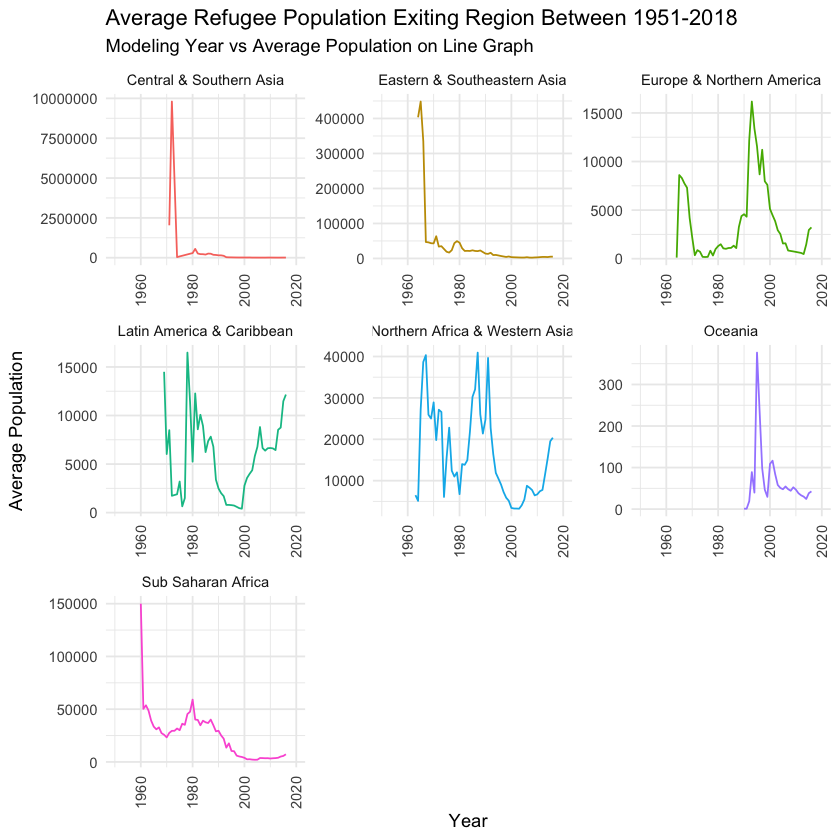

In [13]:
ggplot(origin_df, aes(x=year, y=avg_pop, color = region_origin)) +
  geom_line() +
  labs(
    title="Average Refugee Population Exiting Region Between 1951-2018", 
    subtitle="Modeling Year vs Average Population on Line Graph", 
    x="Year", 
    y="Average Population"
    ) +
  scale_x_continuous(limits = c(1950,2020)) + 
  facet_wrap(
    ~region_origin, 
    scales='free', 
    labeller = labeller(region_origin = rename_region)
    ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
    legend.position="none"
    )

# ggsave("figures/region_origin_linegraph.jpeg")

The "origin_df" boxplot shows average "total population" quartiles for each region.

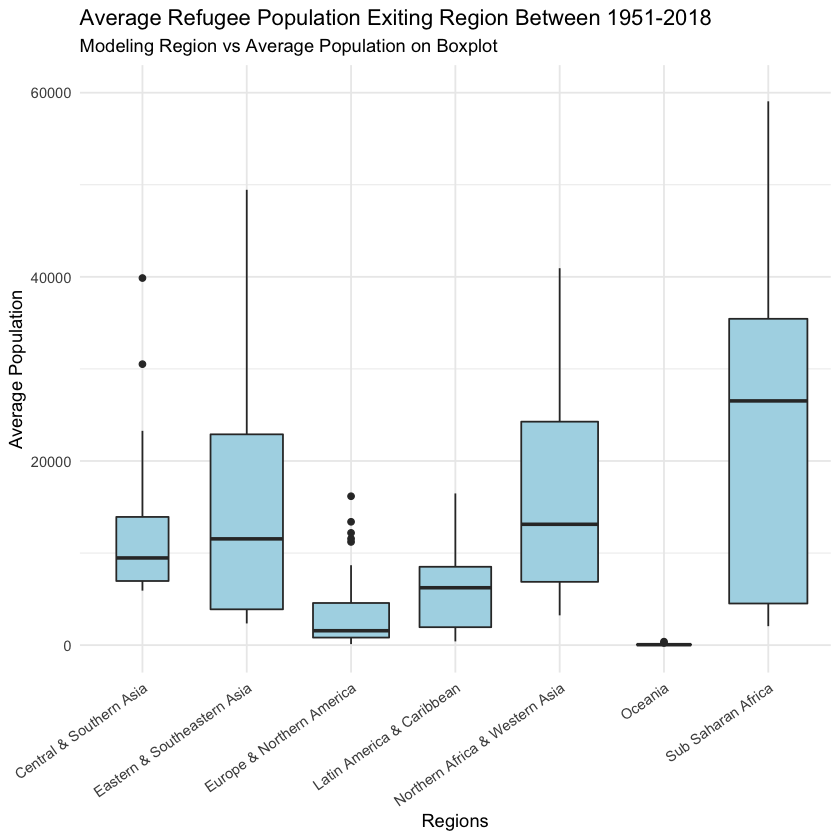

In [14]:
ggplot(origin_df, aes(x=region_origin, y=avg_pop)) +
  geom_boxplot(varwidth = T, fill="light blue") +
  labs(
    title = "Average Refugee Population Exiting Region Between 1951-2018",
    subtitle = "Modeling Region vs Average Population on Boxplot",
    x = "Regions",
    y = "Average Population"
  ) +
  scale_x_discrete(labels=rename_region) +
  scale_y_continuous(limits = c(0,60000)) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 35, hjust = 1))

# ggsave("figures/region_origin_boxplot.jpeg")